# Coexpresion analysis for HBEC IFN experiment

In [25]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

import statsmodels.formula.api as smf
import statsmodels.api as sm

In [26]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [27]:
data_path = '/data_volume/memento/hbec/'
# fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [28]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [29]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Read 1D HT results

In [30]:
cts = ['C', 'B', 'BC', 'all_ct']
tps = [ '3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [31]:
def read_result(ct):
    
    ht_dict = {}
    moments_dict = {}
    
    for stim in stims:
        ht_dict[stim] = {}
        moments_dict[stim] = {}
        for tp in tps: 
            adata_subset = sc.read(data_path + '/binary_test_latest/{}_{}_{}.h5ad'.format(ct, stim, tp))
            ht_dict[stim][tp] = memento.get_1d_ht_result(adata_subset)
            ht_dict[stim][tp]['de_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['de_pval'])
            ht_dict[stim][tp]['dv_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['dv_pval'])
            moments_dict[stim][tp] = memento.get_1d_moments(adata_subset, groupby='time_step')
    return ht_dict,moments_dict

In [33]:
all_moment = {}
all_ht = {}
for ct in cts:
    all_ht[ct], all_moment[ct] = read_result(ct)

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log


In [ ]:
tp = '6'
ct = 'all_ct'
for idx, stim in enumerate(stims):
    
    if idx == 0:
        df = all_ht[ct][stim][tp][['gene', 'de_coef', 'de_pval', 'de_fdr']].rename(columns=dict(zip(['de_coef', 'de_pval', 'de_fdr'], ['logfc_'+stim, 'pv_'+stim, 'fdr_'+stim])))
    else:
        a = all_ht[ct][stim][tp][['gene', 'de_coef', 'de_pval', 'de_fdr']].rename(columns=dict(zip(['de_coef', 'de_pval', 'de_fdr'], ['logfc_'+stim, 'pv_'+stim, 'fdr_'+stim])))
        df = df.merge(a, on='gene', how='outer')

### Graph ISG comparisons for each stim

In [23]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [24]:
x.max()

3.1551432069722263

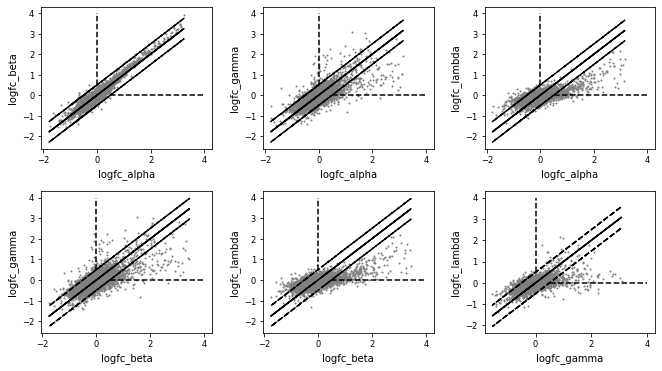

In [16]:
plt.figure(figsize=(11, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
cols = ['logfc_alpha','logfc_beta', 'logfc_gamma', 'logfc_lambda']
for idx, c in enumerate(itertools.combinations(cols,2)):
    
    subset = df[[c[0], c[1]]].copy()
    subset.dropna(inplace=True)

    x, y = subset[c[0]], subset[c[1]]

    plt.subplot(2, 3, idx+1)
    plt.scatter(x, y, s=1, color='grey');
    plt.xlabel(c[0]); plt.ylabel(c[1])
    # plt.plot([-1.5, 3], [-1.5, 3])
    xs = np.arange(0, x.max())
    plt.plot(x,x+0.5, '--', color='k')
    xs = np.arange(0.5, x.max())
    plt.plot(x,x, color='k')
    xs = np.arange(0, x.max()+0.5)
    plt.plot(x,x-0.5, '--', color='k')
    plt.plot([0, 0], [0.5, 4], '--', color='k')
    plt.plot([0.5, 4], [0, 0], '--', color='k')
#     plt.plot([0, 0.5, 0.5], [0.5, 0.5, 0], '--', color='k')

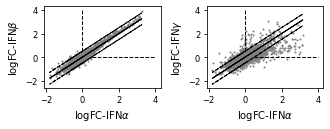

In [25]:
plt.figure(figsize=(5, 1.5))
plt.subplots_adjust(wspace=0.4)
cols = ['logfc_alpha','logfc_beta', 'logfc_gamma', 'logfc_lambda']
for idx, c in enumerate(itertools.combinations(cols,2)):
    
    subset = df[[c[0], c[1]]].copy()
    subset.dropna(inplace=True)

    x, y = subset[c[0]], subset[c[1]]
    plt.subplot(1, 2, idx+1);

    plt.scatter(x, y, s=1, color='grey');
    plt.xlabel(c[0]); plt.ylabel(c[1])
    # plt.plot([-1.5, 3], [-1.5, 3])
    xs = np.arange(0, x.max())
    plt.plot(x,x+0.5, '--', color='k', lw=1)
    xs = np.arange(0.5, x.max())
    plt.plot(x,x, color='k', lw=1)
    xs = np.arange(0, x.max()+0.5)
    plt.plot(x,x-0.5, '--', color='k', lw=1)
    plt.plot([0, 0], [0.5, 4], '--', color='k', lw=1)
    plt.plot([0.5, 4], [0, 0], '--', color='k', lw=1)
    plt.xlabel(r'logFC-IFN$\alpha$')

    if idx == 0:
        plt.ylabel(r'logFC-IFN$\beta$')
    if idx == 1:
        plt.ylabel(r'logFC-IFN$\gamma$')
        break
plt.savefig('stim_lfc_scatter.png', bbox_inches='tight', dpi=500)

### Create long/wide form of HT results

In [26]:
# Create longform data

longform = []
    
for stim in stims:

    for tp in tps:
        a = all_ht['all_ct'][stim][tp]
        a['tp'] = int(tp)
        a['ct'] = 'all_ct'
        a['stim'] = stim
        a['lfc'] = a['de_coef']
        a['fdr'] = a['de_fdr']
        longform.append(a[['gene', 'lfc', 'tp', 'stim', 'fdr']].copy())

longform = pd.concat(longform)


In [27]:
wideform = longform.pivot(index='gene', columns=['stim', 'tp'], values=['lfc', 'fdr'])#.loc[:, 'C'].loc[:, ['control', '']
wideform_fdr = longform.pivot(index='gene', columns=['stim', 'tp'], values=['fdr'])#.loc[:, 'C'].loc[:, ['control', '']
wideform_hr = wideform.xs(6, level='tp', axis=1)

### Define type specific/shared ISGs

In [47]:
isg_types = ['type1', 'type2', 'shared', 'any']
tps = [3, 6, 9, 24, 48]
tps=[6]
isg_class_df = pd.DataFrame()
for tp in tps:
    wideform_hr = wideform.xs(tp, level='tp', axis=1)
    for isg_type in isg_types:
        if isg_type == 'type2': # gamma

            type1_both = wideform_hr['lfc'][['alpha', 'beta']].min(axis=1)
            rest = pd.concat([type1_both, wideform_hr['lfc']['lambda']], axis=1).max(axis=1)
            isg_class_df['is_type2_{}'.format(tp)] = (wideform_hr['lfc']['gamma'] > 0.5) & (wideform_hr['lfc']['gamma'] > rest + 0.5) & (wideform_hr['fdr']['gamma'] < 0.05) 

        if isg_type == 'type1':

            type1_both = wideform_hr['lfc'][['alpha', 'beta']].max(axis=1)
            rest = pd.concat([wideform_hr['lfc']['gamma'], wideform_hr['lfc']['lambda']], axis=1).max(axis=1)
            isg_class_df['is_type1_{}'.format(tp)] = (type1_both > 0.5) & (type1_both > rest + 0.5) & ((wideform_hr['fdr']['beta'] < 0.05) | (wideform_hr['fdr']['alpha'] < 0.05))

        if isg_type == 'shared':

            isg_class_df['is_shared_{}'.format(tp)] = (wideform_hr['lfc'][['alpha', 'beta', 'gamma']].min(axis=1) > 0.5) & (wideform_hr['fdr'][['alpha', 'beta', 'gamma']].max(axis=1) < 0.05)
            isg_class_df['is_shared_{}'.format(tp)] = isg_class_df['is_shared_{}'.format(tp)] & ~isg_class_df['is_type1_{}'.format(tp)] & ~isg_class_df['is_type2_{}'.format(tp)]
#         if isg_type == 'any':

#             isg_class_df['is_any_{}'.format(tp)] = (wideform_hr['lfc'][['alpha', 'beta', 'gamma']].max(axis=1) > 0.5) & (wideform_hr['fdr'][['alpha', 'beta', 'gamma']].min(axis=1) < 0.05)


isg_class_df = isg_class_df[isg_class_df.sum(axis=1) > 0].copy()


### Consolidate an ISG class for each gene

In [48]:
def classify(row):
    
    t1 = 0
    t2 = 0
    shared = 0
        
    for idx, val in zip(row.index, row):
        
        if 'type1' in idx:
            t1 += val
        elif 'type2' in idx:
            t2 += val
        elif 'shared' in idx:
            shared += val
    if max(t1, t2, shared) == t1:
        return 'type1'
    elif max(t1, t2, shared) == t2:
        return 'type2'
    elif max(t1, t2, shared) == shared:
        return 'shared'
    

In [49]:
isg_class_df['overall_type'] = isg_class_df.apply(classify, axis=1)
isg_class_df.to_csv('../isg_classes.csv')

In [50]:
isg_class_df.shape

(500, 4)

In [51]:
isg_class_df.overall_type.value_counts()

type1     251
shared    182
type2      67
Name: overall_type, dtype: int64

### DE gene heatmap

In [34]:
from matplotlib.colors import LinearSegmentedColormap


pal = sns.husl_palette(3, s=.45)
lut = dict(zip(['type1', 'type2', 'shared'], pal))
lut_ind = dict(zip(['type1', 'type2', 'shared'], [-1, 0, 1]))
colors = isg_class_df['overall_type'].map(lut)
colors_ind = isg_class_df['overall_type'].map(lut_ind)

myColors = sns.color_palette('husl')[:3]
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))



In [300]:
heatmap_list = []
for t in ['type1', 'type2', 'shared']:
    heatmap = wideform['lfc'].loc[isg_class_df.query('overall_type == "{}"'.format(t)).index]
    g = sns.clustermap(heatmap.fillna(0.0),cmap='coolwarm', col_cluster=False, metric='euclidean', center=0, vmax=2.5, row_colors=colors)
    inds = g.dendrogram_row.reordered_ind
    plt.close()
    heatmap_list.append(heatmap.iloc[inds])
heatmap = pd.concat(heatmap_list)

sorted_colors = \
    [-1 for i in range(heatmap_list[0].shape[0])] + \
    [0 for i in range(heatmap_list[1].shape[0])] + \
    [1 for i in range(heatmap_list[2].shape[0])]
sorted_colors = pd.DataFrame(sorted_colors)

In [351]:
nan_idx = (np.isnan(heatmap).sum(axis=1) < 2).values

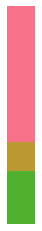

In [355]:
plt.figure(figsize=(0.5,4))

sns.heatmap(sorted_colors.loc[nan_idx], cmap=cmap, yticklabels=False, xticklabels=False,cbar=False)
plt.savefig('de_heatmap_type.pdf', bbox_inches='tight')

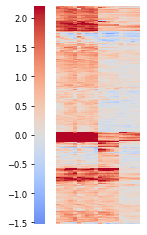

In [357]:
plt.figure(figsize=(2,4))

sns.heatmap(heatmap.loc[nan_idx].fillna(0.0), vmax=2.2, center=0, cmap='coolwarm', yticklabels=False, xticklabels=False, cbar_kws = dict(use_gridspec=False,location="left"))
plt.xlabel(None); plt.ylabel(None)

plt.savefig('de_heatmap.png', bbox_inches='tight')

### Read ISG classes

In [52]:
isg_classes = pd.read_csv('../isg_classes.csv')
t1_isg = isg_classes.query('overall_type =="type1"').gene.tolist()
t2_isg = isg_classes.query('overall_type =="type2"').gene.tolist()
shared_isg = isg_classes.query('overall_type == "shared"').gene.tolist()
all_isg = isg_classes[isg_classes.sum(axis=1) > 0].gene.tolist()

In [53]:
len(all_isg)

500

### Examine stimulation pattern across time

In [110]:
stim = 'alpha'
ct = 'C'


adata = sc.read(data_path + 'binary_test_latest/{}_{}_stim.h5ad'.format(ct, stim))
ht_1d = memento.get_1d_ht_result(adata)
moments_m, moments_v = memento.get_1d_moments(adata, groupby='time_step')
moments_m = moments_m[['gene','time_step_0', 'time_step_1', 'time_step_2', 'time_step_3', 'time_step_4']]
moments_v= moments_v[['gene','time_step_0', 'time_step_1', 'time_step_2', 'time_step_3', 'time_step_4']]

ht_1d = ht_1d.loc[ht_1d['gene'].isin(all_isg),].copy()

ht_1d['de_fdr'] = memento.util._fdrcorrect(ht_1d['de_pval'])
ht_1d['dv_fdr'] = memento.util._fdrcorrect(ht_1d['dv_pval'])

In [111]:
ht_1d = ht_1d.merge(moments_m, on='gene').merge(moments_v, on='gene', suffixes=('_m', '_v'))

In [112]:
stats.pearsonr(ht_1d['de_coef'], ht_1d['dv_coef'])

(0.0890452371278869, 0.07864323843950617)

In [114]:
ht_1d.query('dv_fdr < 0.5').sort_values('dv_coef', ascending=False).head(50)

gene   de_coef     de_se       de_pval   dv_coef     dv_se  \
375  AL021707.6  0.040055  0.025957  1.228078e-01  0.405751  0.085825   
13       IFI44L -0.094717  0.007270  8.375352e-39  0.287523  0.026252   
272        GCH1  0.387374  0.025361  1.127989e-52  0.286315  0.058526   
171      SAMD9L  0.079647  0.010549  4.338171e-14  0.236363  0.030400   
197       TDRD7  0.106556  0.020492  1.995449e-07  0.214538  0.120466   
129   HIST1H2BJ -0.229767  0.041225  2.497129e-08  0.210969  0.157935   
365         MX2 -0.089979  0.008706  4.874041e-25  0.209878  0.025934   
243      CLEC2B  0.392833  0.038550  2.193058e-24  0.198125  0.120291   
359        ZBP1  0.039503  0.015079  8.799914e-03  0.197843  0.046021   
64       SP140L  0.158924  0.017886  6.355739e-19  0.196636  0.081894   
102      DDX60L  0.133277  0.010714  1.604419e-35  0.192040  0.029224   
366         MX1  0.030222  0.008384  3.122615e-04  0.190511  0.021796   
195       DDX58  0.189663  0.011014  1.868049e-66  0.189377  0.026531   
109       PARP8  0.180089  0.014865  8.798257e-34  0.182571  0.060173   
285      DUOXA2 -0.293446  0.028440  5.848500e-25  0.182235  0.047890   
167     C1GALT1  0.166279  0.013791  1.785716e-33  0.181043  0.056244   
331      RNF213  0.166939  0.010115  3.430398e-61  0.180048  0.024050   
47         MALL  0.139471  0.031487  9.445580e-06  0.176541  0.082117   
237       MMP13  0.547779  0.030662  2.203221e-71  0.172796  0.063281   
261      EPSTI1  0.050784  0.010236  7.001686e-07  0.172374  0.033810   
54       CHROMR  0.147033  0.016877  2.991549e-18  0.167901  0.061408   
60       CASP10  0.069370  0.026595  9.098355e-03  0.167447  0.086717   
168        SCIN  0.069106  0.015713  1.092987e-05  0.162099  0.063721   
101       DDX60  0.140733  0.010506  6.420655e-41  0.160119  0.032549   
271        TGM1  0.113940  0.041864  6.494807e-03  0.149735  0.077262   
196       FRMD3 -0.181435  0.028599  2.238278e-10  0.148894  0.082359   
229       PATL1  0.024067  0.025497  3.452165e-01  0.148076  0.132424   
249       RBMS2 -0.030908  0.018503  9.483052e-02  0.147990  0.095713   
319       GSDMB -0.061150  0.015782  1.067290e-04  0.147394  0.062139   
162        VNN3 -0.158755  0.012800  2.517914e-35  0.144835  0.036522   
76         XRN1  0.081532  0.010562  1.165956e-14  0.144348  0.039502   
213    SLC25A28  0.166060  0.012340  2.809030e-41  0.141722  0.040925   
248       STAT2 -0.025204  0.010765  1.922051e-02  0.137206  0.034447   
351       KLK10  0.015912  0.025515  5.328653e-01  0.133845  0.091339   
122         ID4  0.372896  0.027807  5.257115e-41  0.132097  0.050447   
191      PARP10 -0.066184  0.013276  6.192379e-07  0.129808  0.070807   
221      TRIM21  0.118172  0.020679  1.100260e-08  0.129131  0.082461   
214         SCD -0.004114  0.024925  8.688914e-01  0.126603  0.075638   
339        SHFL  0.047693  0.010606  6.903142e-06  0.126011  0.035038   
284       DUOX2 -0.375810  0.020592  2.059207e-74  0.124555  0.037889   
254        OAS3  0.003730  0.009632  6.985604e-01  0.123393  0.029485   
65        SP100  0.037187  0.009297  6.341534e-05  0.122030  0.034329   
145     HLA-DMB -0.150669  0.025833  5.465492e-09  0.121839  0.107333   
9        RNF19B  0.152397  0.020367  7.299823e-14  0.117951  0.075759   
305      CX3CL1  0.209094  0.023414  4.242247e-19  0.116798  0.052337   
74       PARP14 -0.035697  0.007846  5.376403e-06  0.116516  0.023715   
126   HIST1H2AC -0.250965  0.020601  3.875005e-34  0.116105  0.042925   
324      TRIM25  0.170987  0.013253  4.395161e-38  0.114784  0.041551   
382        TYMP -0.109434  0.007729  1.662682e-45  0.114560  0.031565   
371       APOL4  0.297641  0.021571  2.621245e-43  0.112630  0.040617   

          dv_pval        de_fdr        dv_fdr  time_step_0_m  time_step_1_m  \
375  2.271345e-06  1.455087e-01  2.114514e-05      -1.471311      -1.349621   
13   6.461200e-28  5.847790e-38  8.421097e-26       2.261272       2.181557   
272  9.975732e-07  1.225121e-51  9.513442e-06     

In [76]:
import gseapy as gp

In [103]:
pre_res = gp.prerank(rnk=ht_1d[['gene', 'de_coef']].sort_values('de_coef', ascending=False), 
                     gene_sets='GO_Molecular_Function_2018',
                     processes=30,
                     permutation_num=100, # reduce number to speed up testing
                     outdir=None, seed=6)

In [109]:
pre_res.res2d.query('es < 0').query('fdr < 0.2').head(50)


es      nes  pval  \
Term                                                                     
UDP-glycosyltransferase activity (GO:0008194) -0.563725 -1.64848   0.0   

                                                    fdr  geneset_size  \
Term                                                                    
UDP-glycosyltransferase activity (GO:0008194)  0.187559            64   

                                               matched_size  \
Term                                                          
UDP-glycosyltransferase activity (GO:0008194)            17   

                                                                                           genes  \
Term                                                                                               
UDP-glycosyltransferase activity (GO:0008194)  B3GNT2;HEXA;POMGNT1;MGAT1;B3GALT6;HEXB;B3GALT4...   

                                                                                     ledge_genes  
Term                                                                                              
UDP-glycosyltransferase activity (GO:0008194)  EXT1;B3GNT7;OGT;B4GALT1;POGLUT1;GXYLT1;B3GNT5;...

In [104]:
pre_res.res2d.query('es > 0').head(50)


es       nes  \
Term                                                                     
NADH dehydrogenase (quinone) activity (GO:0050136)  0.646562  2.199029   
NADH dehydrogenase (ubiquinone) activity (GO:00...  0.646562  2.142047   
mRNA 5'-UTR binding (GO:0048027)                    0.740198  2.143327   
oxidoreductase activity, acting on the CH-OH gr...  0.600984  2.022405   
cytokine activity (GO:0005125)                      0.629656  1.976631   
glutathione transferase activity (GO:0004364)       0.723805  1.983506   
rRNA binding (GO:0019843)                           0.610771  1.992955   
hydro-lyase activity (GO:0016836)                   0.636882  1.809650   
translation factor activity, RNA binding (GO:00...  0.516887  1.795971   
chemokine receptor binding (GO:0042379)             0.651822  1.740624   
protein serine/threonine kinase inhibitor activ...  0.601948  1.715730   
mRNA binding (GO:0003729)                           0.422763  1.707595   
translation initiation factor activity (GO:0003...  0.539383  1.676525   
poly-pyrimidine tract binding (GO:0008187)          0.589018  1.662760   
pyrophosphatase activity (GO:0016462)               0.565404  1.647148   
cholesterol binding (GO:0015485)                    0.633869  1.639690   
hydrogen ion transmembrane transporter activity...  0.536312  1.595273   
serine-type endopeptidase inhibitor activity (G...  0.574541  1.580003   
peptidase activity, acting on L-amino acid pept...  0.413605  1.583073   
single-stranded RNA binding (GO:0003727)            0.511130  1.559999   
sterol binding (GO:0032934)                         0.581417  1.543244   
calcium ion binding (GO:0005509)                    0.410907  1.531559   
ion channel inhibitor activity (GO:0008200)         0.563474  1.461177   
endonuclease activity (GO:0004519)                  0.473887  1.469903   
double-stranded DNA binding (GO:0003690)            0.419352  1.464037   
myosin binding (GO:0017022)                         0.496257  1.442524   
copper ion binding (GO:0005507)                     0.515489  1.430566   
kinase inhibitor activity (GO:0019210)              0.498859  1.452680   
endopeptidase inhibitor activity (GO:0004866)       0.434415  1.423895   
cysteine-type endopeptidase inhibitor activity ...  0.487688  1.434206   
mRNA 3'-UTR binding (GO:0003730)                    0.425393  1.446016   
GTP binding (GO:0005525)                            0.362080  1.395294   
protease binding (GO:0002020)                       0.400874  1.397688   
zinc ion binding (GO:0008270)                       0.344565  1.405016   
purine ribonucleoside binding (GO:0032550)          0.350123  1.401064   
transition metal ion binding (GO:0046914)           0.324199  1.353573   
ribonuclease activity (GO:0004540)                  0.458242  1.359347   
endopeptidase regulator activity (GO:0061135)       0.477086  1.353811   
cyclin-dependent protein serine/threonine kinas...  0.488444  1.368819   
guanyl ribonucleotide binding (GO:0032561)          0.346902  1.359387   
transcriptional repressor activity, RNA polymer...  0.406107  1.360628   
double-stranded RNA binding (GO:0003725)            0.394615  1.317929   
cysteine-type endopeptidase activity (GO:0004197)   0.384833  1.319156   
metal ion binding (GO:0046872)                      0.319834  1.319384   
protein homodimerization activity (GO:0042803)      0.312524  1.332525   
tRNA binding (GO:0000049)                           0.461866  1.320135   
GTPase binding (GO:0051020)                         0.394658  1.326122   
protein kinase inhibitor activity (GO:0004860)      0.428113  1.322077   
ribosome binding (GO:0043022)                       0.424890  1.300755   
RNA polymerase II core promoter sequence-specif...  0.481181  1.290551   

                                                        pval       fdr  \
Term                                                                     
NADH dehydrogenase (quinone) activity (GO:0050136)  0.000000 